# Pre-training transferlearning for depth estimation
This is the main file for the computer vision project. Before using this file, pay attention to the following
## Data preprocessing
The NYU v2 data set is used and can be downloaded here [Nyuv2 dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html). the processing can be done using the [convert_dataset.ipynb](https://colab.research.google.com/drive/19JpS4vjU-dIvLX1HphdYU8aiNxQ_rFls?usp=drive_link). in this file make sure to change the dataset_dir to the location where the `nyu_depth_v2_labeled.mat` file is located ,this is also the location where the unzipped data will be stored.

## Running the model
If it is desired to train the model, use the `main` function and read the instrunction in [that cell](#scrollTo=UqqPGgWZHk_i&line=1&uniqifier=1).

To only run the validation run the cell [here](#scrollTo=vAxXkB63M_uJ&line=1&uniqifier=1)

Training variables such as the optimizer and loss function can be change in [this cell](#scrollTo=NmqgysHxM9d9&line=1&uniqifier=1)
## Model
For the experiment a model architecture was used from the paper [Deeper Depth Prediction with Fully Convolutional Residual Networks](https://ieeexplore-ieee-org.tudelft.idm.oclc.org/document/7785097), it is a Resnet50 based model, with an upsampling end instead of the 2048x1000 fully connected layer, that was used for the pretrained model.
The Resnet50 model is used once with all weights and once with a mask provided by the VITA research group from the paper [The Lottery Tickets Hypothesis for Supervised and Self-supervised Pre-training in Computer Vision Models.](https://arxiv.org/abs/2012.06908).
## Results
The model was trained two times, one time it used the masked model provided by (paper) on both the model and the gradients during training. The second time the full model was used.
For training we used the same optimizer and loss functions as used for the [Deeper Depth Prediction with Fully Convolutional Residual Networks](https://ieeexplore-ieee-org.tudelft.idm.oclc.org/document/7785097) paper. We used a train/validate split of 1200/200 and trained both model till convergence. The MSE, RMSE and log10MSE can be found in the table below.

| MODEL| MSE | RMSE | log10 |
|------|-----|-----|-----|
|Dense Resnet50| xxx | xxx | xxx |
|Pruned Resnet50| xxx | xxx | xxx


In [11]:
# import os
# from google_auth_oauthlib.flow import InstalledAppFlow
# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials

# # Path to the credentials file you downloaded
# credentials_file = '/home/olaf/credentials.json'

# # Scopes required for accessing Google Drive
# scopes = ['https://www.googleapis.com/auth/drive.readonly']

# # Authenticate and authorize access to Google Drive
# flow = InstalledAppFlow.from_client_secrets_file(credentials_file,scopes)
# creds = flow.run_local_server(port=0)

# # Create the Drive service
# drive_service = build('drive', 'v3', credentials=creds)

In [12]:

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments
import os
import h5py
import math
import time
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
#import models.resnet as resnet
import cv2
import numpy as np
# import dataset
import PIL.Image as Image
from IPython.display import clear_output
import network.FCRN as FCRN
import matplotlib.pyplot as plt
from network.FCRN_add_ons import log10, berHuLoss, Result


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1kbr0lOVBd0ZwibVk1AvJDKkTpt1k440d/CV_LTH_pre-training_depth-estimation_experiments


In [13]:
torch.cuda.empty_cache()
def h5_loader(path):
    h5f = h5py.File(path, "r")
    rgb = np.array(h5f['rgb'])
    rgb = np.transpose(rgb, (2, 1, 0))

    rgb=Image.fromarray(rgb)
    #
    depth = Image.fromarray(np.transpose(np.array(h5f['depth'])))
    return rgb, depth

output_shape=(228,304)
lr=0.0001
momentum=0.9
weight_decay=0.01

transform=transforms.Compose([
            transforms.Resize(250),
            transforms.CenterCrop((228,304)),
            transforms.ToTensor(),])

if torch.cuda.is_available():
    device='cuda'
    print('cuda available using gpu')
else:
    device='cpu'
    print('cuda not available running on cpu')
model_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/"
#####         Change to the location and used mask to be used in training and validation          #####
checkpoint_mask=torch.load(model_dir+"mask-18.pt", map_location=device)
pretrained_model=torch.load(model_dir+"imagenet_weight.pt", map_location=device)

#####          remove final layers to allow edited architecture          #####
del pretrained_model["fc.weight"], pretrained_model['fc.bias']

model = FCRN.ResNet(output_size=(228,304),pretrained=False)
print((model.state_dict()['layer1.0.conv1.weight']==0).sum())
current_model_dict=model.state_dict()
current_model_dict.update(pretrained_model)

####          if masking required this masks the model  ALSO NEEDS TO BE CHANGED IN def train()          #####

# for key in checkpoint_mask.keys():
#   current_model_dict[key[:-5]]=checkpoint_mask[key]*current_model_dict[key[:-5]]

model.load_state_dict(current_model_dict)
print('if mask applied previous should be 0, and below should not be 0')
print((model.state_dict()['layer1.0.conv1.weight']==0).sum())
print("=> model created.")
start_epoch = 0
# different modules have different learning rate
train_params = [{'params': model.get_1x_lr_params(), 'lr': lr},
                {'params': model.get_10x_lr_params(), 'lr': lr * 10}]

optimizer = torch.optim.SGD(train_params, lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion =berHuLoss()#nn.MSELoss()#berHuLoss()
model=model.to(device=device)

torch.cuda.empty_cache()

cuda not available running on cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor(0)
if mask applied previous should be 0, and below should not be 0
tensor(0)
=> model created.


In [18]:

def train(train_list,batchsize,current_epoch,checkpoint_mask,model=model):

  # checkpoint_mask=checkpoint_mask.to(device)
  end=time.time()
  model.train()
  for i,img_path in enumerate(train_list[::batchsize]):
    #####             LOADING DATA            #####
      im_list=torch.Tensor().to(device)
      depth_list=torch.Tensor().to(device)
      i=batchsize*i
      losses=[]
      for id in range(i,i+batchsize):
          try:

              im,depth=h5_loader(traindir+train_list[id])
          except Exception as error:
              print('failed', error)
              pass
          else:
              im=transform(im).to(device)
              depth=transform(depth).to(device)
              im_list=torch.cat((im_list,im)).to(device=device)
              depth_list=torch.cat((depth_list,depth)).to(device=device)

      im_tensor=im_list.reshape((batchsize,*im.shape))
      target=depth_list.reshape((batchsize,*depth.shape))

      #####         RUNNING MODEL AND UPDATING VALUES         #####

      print((model.state_dict()['layer1.0.conv1.weight']==0).sum())
      if torch.cuda.is_available():
        torch.cuda.synchronize()
      data_time = time.time() - end
      end =time.time()

      output=model(im_tensor)

      loss = criterion(output,target)
      optimizer.zero_grad()
      loss.backward()

      losses.append(loss)


      ####          MAKSING THE GRADS           #####
      #            Comment out if a dense model is desired        ######
      # for name, param in model.named_parameters():
      #   if param.requires_grad:
      #     if name+"_mask" in checkpoint_mask.keys():
      #       # print(1,(param.grad==0).sum())
      #       param.grad*=checkpoint_mask[name+"_mask"]
      #       # print(2,(param.grad==0).sum())

      optimizer.step()
      before_sum=0
      after_sum=0

      print((model.state_dict()['layer1.0.conv1.weight']==0).sum())
      if torch.cuda.is_available():
        torch.cuda.synchronize()
      gpu_time = time.time() - end

      # measure accuracy and record loss
      ######          SAVING RESULTS           ######
      result = Result()
      result.evaluate(output.data, target.data)

      print("epoch {}: {} of {} items done, with a loss of {}".format(current_epoch,i+batchsize,len(train_list),loss))

      end = time.time()

  clear_output()
  return result,losses

def validate(val_list,val_indices,model=model):
  model.eval()
  end =time.time()
  losses=[]
  #####             LOADING DATA            #####
  for i in val_indices:
    print(i)
    im_list=torch.Tensor().to(device)
    depth_list=torch.Tensor().to(device)

    for id in range(i,i+batchsize):
        try:
            im,depth=h5_loader(valdir+val_list[id])
        except Exception as error:
            print('failed', error)
            pass
        else:
            im=transform(im).to(device)
            depth=transform(depth).to(device)
            im_list=torch.cat((im_list,im)).to(device=device)
            depth_list=torch.cat((depth_list,depth)).to(device=device)

    im_tensor=im_list.reshape((batchsize,*im.shape))
    depth_list=depth_list.reshape((batchsize,*depth.shape))
    target=depth_list

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    data_time = time.time() - end

    with torch.no_grad():
      output=model(im_tensor)
      loss_val=criterion(output,target)
      losses.append(loss_val.item())

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    gpu_time = time.time() - end

    # measure accuracy and record loss
    result = Result()
    result.evaluate(output.data, target.data)

    end = time.time()
  return result,losses

def main(checkpoint_mask,train_list,val_list,val_indices,batchsize,epochs,resume=False,model=model,model_dir="content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/",resume_path="content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/checkpoint.pt"):

  end = time.time()
  epoch_train_losses=[]
  epoch_val_losses=[]
  if resume:
    checkpoint=torch.load(resume_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    val_result,val_loss=validate(val_list,val_indices)
    best_rmse=val_result.rmse


  # val_avg,val_loss=validate(val_list,val_indices)
  # print("check these values [initial validation rmse {}, average loss {}]".format(val_avg.rmse,np.average(val_loss)))
  # del val_avg, val_loss
  for epoch in range(epochs):
    print('epoch:{}'.format(epoch))
    #####         TRAINING  AND VALIDATING        #####

    print((model.state_dict()['layer1.0.conv1.weight']==0).sum())
    train_result,train_loss=train(train_list,batchsize,epoch,checkpoint_mask,model=model)
    print((model.state_dict()['layer1.0.conv1.weight']==0).sum())

    if epoch==1 and not resume:
      best_rmse=val_result.rmse
    val_result,val_loss=validate(val_list,val_indices,model=model)
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict':optimizer.state_dict()},model_dir+"checkpoint_dense_extra.pt")
    if epoch>0:
      if val_result.rmse<best_rmse:
        if resume:
          epoch=epoch+checkpoint['epoch']
        best_rmse=val_result.rmse
        best_model=model.state_dict()
        torch.save({'epoch': epoch, 'model_state_dict': best_model, 'optimizer_state_dict':optimizer.state_dict()},model_dir+"best_model_dense_extra.pt")
      elif val_result.rmse>best_rmse:

        print('train avg: {} and validate avg: {}'.format(train_result.rmse,val_result.rmse))
        print('early stopping applied')
        # return epoch_train_losses, epoch_val_losses, train_result, val_result

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(np.average(val_loss))
    print('train avg: {} and validate avg: {}'.format(train_result.rmse,val_result.rmse))
  return epoch_train_losses, epoch_val_losses, train_result, val_result



In [15]:
print((model.state_dict()['layer1.0.conv1.weight']==0).sum())

tensor(0)


In [16]:
torch.cuda.empty_cache()
######    Set RUN=true to run the main function
#         if you want to resume the training from a file, make sure the file is of the following formatdict['epoch':int,'model_state_dict':dict,'optimizer_state_dict':dict]
#         make sure to use the convert data file before running this file!!!
run_main=False
model_save_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/new/"
dataset_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/dataset/"
continue_from_existing_file=True
continue_training_file='/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/new/checkpoint_sparse.pt'
batchsize=50

traindir=dataset_dir+"train/"
valdir=dataset_dir+"val/"
train_list=os.listdir(traindir)
val_list=os.listdir(valdir)

#### edit this list only if a different number of files is used, make sure the final index is n_val_file - batchsize
val_indices=[0,50,100,150,199]#val_indices=[0,40,80,120,160,209]


if run_main:
  torch.cuda.empty_cache()
  train_losses,val_losses,train_result, val_result=main(checkpoint_mask,train_list,val_list,val_indices,batchsize,10,resume=continue_from_existing_file,model=model,model_dir=model_save_dir,resume_path=continue_training_file)

In [20]:
#####         Set run_validate to true if you want to run only a validation script
run_validate=False

model_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/"
dataset_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/dataset/"
continue_training_file='/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/best_model.pt'
traindir=dataset_dir+"train/"
valdir=dataset_dir+"val/"
train_list=os.listdir(traindir)
val_list=os.listdir(valdir)

#### edit this list only if a different number of files is used, make sure the final index is n_val_file - batchsize
val_indices=[0,50,100,150,199]#[0,40,80,120,160,209]

if run_validate:
  val_result,val_loss=validate(val_list,val_indices,model=model)
  print(val_result)

# Results
The next code is used to get the final results of the model to put inside the blog.

In [21]:
import cv2
from google.colab.patches import cv2_imshow

In [24]:
if torch.cuda.is_available():
    device='cuda'
    print('cuda available using gpu')
else:
    device='cpu'
    print('cuda not available running on cpu')
final_eval=False
model_dir="/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/new/"
#####         Change to the location and used mask to be used in training and validation          #####
checkpoint_masked=torch.load(model_dir+"best_model_sparse.pt", map_location=device)
checkpoint_mask=torch.load("/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/model/mask-18.pt",map_location=device)
checkpoint_dense=torch.load(model_dir+"best_model_dense.pt",map_location=device)

model_masked = FCRN.ResNet(output_size=(228,304),pretrained=False)
model_masked.load_state_dict(checkpoint_masked['model_state_dict'])
model_masked.eval()
model.to(device)
model_dense = FCRN.ResNet(output_size=(228,304),pretrained=False)
model_dense.load_state_dict(checkpoint_dense['model_state_dict'])
model_dense.eval()
model_dense.to(device)
if final_eval:
  val_new,val_old_new=validate(val_list,val_indices,model=model_dense)
  val_sparse,val_sparse_loss=validate(val_list,val_indices,model=model_masked)
  print("=> model created.")
  sum_p=0
  sum_1=0
  for layer in checkpoint_mask:
    sum_p+=checkpoint_mask[layer].numel()
    sum_1+=checkpoint_mask[layer].sum()
  print((sum_1/sum_p)*100)


cuda not available running on cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor(2864)
tensor(2864)
tensor(0)


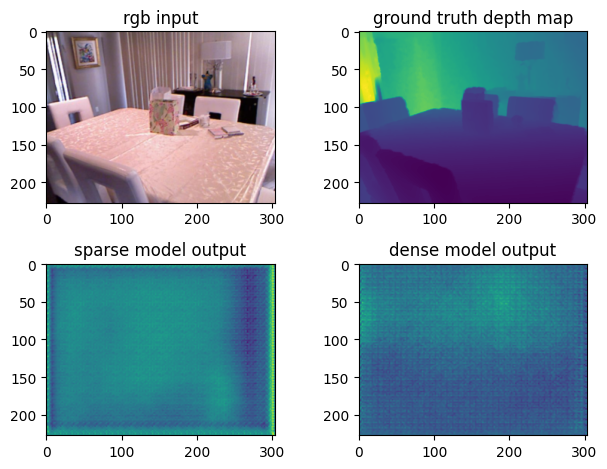

In [38]:

print((checkpoint_mask['layer1.0.conv1.weight_mask']==0).sum())
print((checkpoint_masked['model_state_dict']['layer1.0.conv1.weight']==0).sum())
print((checkpoint_dense['model_state_dict']['layer1.0.conv1.weight']==0).sum())
input_im,input_depth=h5_loader('/content/gdrive/My Drive/CV_LTH_pre-training_depth-estimation_experiments/dataset/val/jpgs1358.h5')

# rgb=Image.fromarray(input_im)
rgb=transform(input_im)[None, :,:,:]

output_masked=model_masked(rgb).detach().numpy().squeeze()
output_dense=model_dense(rgb).detach().numpy().squeeze()

rgb=rgb.detach().numpy().squeeze()
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(rgb,(1,2,0)))
plt.title("rgb input")

plt.subplot(2, 2, 2)
plt.imshow(np.array(transform(input_depth))[0])
plt.title("ground truth depth map")

plt.subplot(2, 2, 3)
plt.imshow(output_masked)
plt.title("sparse model output")

plt.subplot(2, 2, 4)
plt.imshow(output_dense)
plt.title("dense model output")
fig.tight_layout()
plt.show()